<a href="https://colab.research.google.com/github/opherdonchin/ModelsOfTheMotorSystems2021-2/blob/master/Minimum_variance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motor command and movement variance

This is a little simulation which will allow you to play with signal dependent noise and see how it affects movement variance. The idea for this simulation is drawn from the simulations in [Harris and Wolpert, 1998](https://www.nature.com/articles/29528) (Figure 3). However, our version is simpler than theirs because we assume that the motor command is a force command while there simulation adds a 2nd order model of the muscles as well as the second order model of the kinematics. It is not difficult to add your muscle model to this simulation and you are welcome to try.

In any case, in this simulation, we are interested in playing with the shape of the force applied and seeing how that affects the final variance.

In [95]:
import numpy as np

## The simulation

The model of kinematics is a simple second order model of a mass that is being accelerated by a force. The force is specified as the input `u` which is then integrated in time steps to give position. Note that all of the units and everything is contained in the dimensionality of `A` and the other parameters.

The model applies a brake at the end of movement (a force opposite to current velocity) to bring the movement to a stop wherever it is after the end of `u`.



In [96]:
def sim_x(x0, A, B, u, k, brake_steps, brake_gain):
  T_steps = len(u)
  x = [np.array(x0)]
  for i in range(T_steps):
    u1 = u[i].reshape([1,1])
    w = np.random.normal(0, k*np.abs(u[i]), 1)
    x.append(A @ x[i] + B @ (u1+w))
  for i in range(brake_steps): # 20 milliseconds to slow down
    u_brake = -brake_gain*x[-1][1]
    w = np.random.normal(0, k*np.abs(u_brake), 1)
    x.append( A @ x[-1] + B @ (u_brake.reshape([1,1]) + w))
  return x



These are the constants of the second order model.

In [97]:
dt = 0.005 # 5 milliseconds per time step
m = 0.25 # 0.25 kg arm
A = np.array([[1, dt, 0], 
              [0, 1, dt], 
              [0, 0, 0]])
B = np.array([[0],
              [0],
              [1/m]])

This runs the model once using a sinusoidal forcing function. Note that we run it twice. Once without noise to see how far the forcing function will move us. Then we normalize to get a movement of the desired distance and then (in the next section), we run again with noise.

In [98]:
T = 0.5
T_steps = int(T/dt)
brake_T = 0.25
brake_steps = int(brake_T/dt)
brake_gain = 10 # m/s^2 / m/s. The gain of the braking force
u = np.sin(np.linspace(0.0,2.0*np.pi,num=T_steps))
x0 = np.array([[0],[0],[0]])
x_no_noise = sim_x(x0, A, B, u, 0, brake_steps, brake_gain)
d = x_no_noise[-1][0] # Get final distance
desired_d = 0.2 # We want a 20 cm movement
u = u*desired_d/d


In [99]:
x = sim_x(x0, A, B, u, 0.2, brake_steps, brake_gain)
n_steps = len(x)
x = np.stack(x, axis=0).reshape([n_steps,3])

In [100]:
import matplotlib.pyplot as plt

Plot movement, velocity and position for the sinusoidal movement.

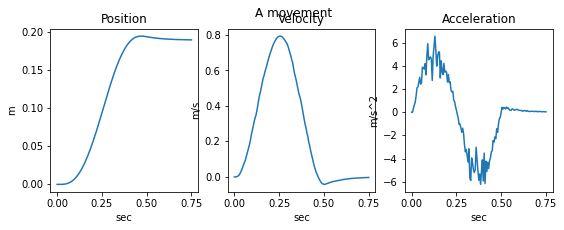

In [101]:
t = np.linspace(0, T+brake_T, n_steps)

plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.plot(t, x[:,0])
plt.title('Position')
plt.ylabel('m')
plt.xlabel('sec')

plt.subplot(132)
plt.plot(t, x[:,1])
plt.title('Velocity')
plt.ylabel('m/s')
plt.xlabel('sec')

plt.subplot(133)
plt.plot(t, x[:,2])
plt.title('Acceleration')
plt.ylabel('m/s^2')
plt.xlabel('sec')

plt.suptitle('A movement')
plt.show()

# Test effect of the shape of the forcing function

To have something that is easy to manipulate, we will take power of the sinusoid. Larger powers will lead to a larger acceleration for a shorter time. Smaller power will lead to a smaller acceleration for a longer time. 

In each case, we normalize so that the overall movement distance is constant.

In [108]:
power = 3
u_power = np.sin(np.linspace(0.0,2.0*np.pi,num=T_steps))
u_power = np.abs(u_power)**power * np.sign(u_power)
x_no_noise = sim_x(x0, A, B, u_power, 0, brake_steps, brake_gain)
d = x_no_noise[-1][0] # Get final distance
u_power = u_power*desired_d/d

## Create the dataset

We run the simulation multiple times so that we can see the variance in the movements.

In [109]:

num_runs = 20
all_x = list()
for run_num in range(num_runs):
  x = sim_x(x0, A, B, u_power, 0.2, brake_steps, brake_gain)
  all_x.append( np.stack(x, axis=0).reshape([n_steps,3]) )


## Plot the different movements

These are the same as the plots above, but we're plotting all fo the runs to give a picture of the variance in the endpoint.

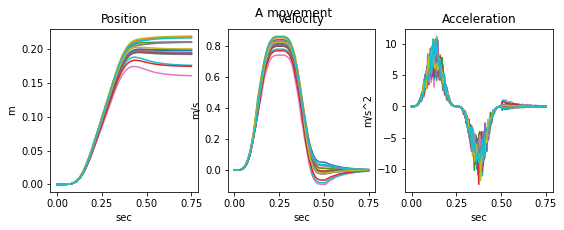

In [110]:
t = np.linspace(0, T+brake_T, n_steps)

plt.figure(figsize=(9, 3))

plt.subplot(131)
for run_num in range(num_runs):
  plt.plot(t, all_x[run_num][:,0])
plt.title('Position')
plt.ylabel('m')
plt.xlabel('sec')

plt.subplot(132)
for run_num in range(num_runs):
  plt.plot(t, all_x[run_num][:,1])
plt.title('Velocity')
plt.ylabel('m/s')
plt.xlabel('sec')

plt.subplot(133)
for run_num in range(num_runs):
  plt.plot(t, all_x[run_num][:,2])
plt.title('Acceleration')
plt.ylabel('m/s^2')
plt.xlabel('sec')

plt.suptitle('A movement')
plt.show()

# Questions

1. Measure the variance of the movement endpoint across runs
2. Manipulate the `power` variable above and see how the variance changes
3. Make a plot of `endpoint variance` against `power`